# Get light-curves from ZTF and PS1 for SNAD catalog

This notebook demonstrates how to get epoch photometry for a custom pointing catalog,
in this case, the [SNAD catalog](https://snad.space/catalog/).
We will get the SNAD catalog as a pandas dataframe, cross-match it with [PS1 DR2 object (OTMO) "detection"](https://outerspace.stsci.edu/display/PANSTARRS/) catalogs and [ZTF DR16 Zubercal](http://nesssi.cacr.caltech.edu/ZTF/Web/Zuber.html) catalog.

## 1. Install and import required packages

In [1]:
# Install lsdb and matplotlib
%pip install --quiet lsdb matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import dask.distributed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lsdb import open_catalog, from_dataframe
from upath import UPath

## 2. Load catalogs

### 2.1. Define paths to PS1 DR2 catalogs

We access all the data through the web, so we don't need to download it in advance.
However, we are going much more data than we're actually going to use, so it will take some time.

In [3]:
# Define paths to PS1 DR2 catalogs
PS1_PATH = UPath("s3://stpubdata/panstarrs/ps1/public/hats/", anon=True)
PS1_OBJECT = PS1_PATH / "otmo"
PS1_DETECTION = PS1_PATH / "detection"

# Define paths to ZTF DR16 Zubercal catalog
ZUBERCAL_PATH = "https://data.lsdb.io/hats/ztf_dr16/zubercal/"

### 2.2. Download and convert SNAD catalog to LSDB format, in memory

[SNAD catalog](https://snad.space/catalog/) is just ~100 rows, we download it through Pandas and convert to LSDB's Catalog object with `lsdb.from_dataframe`.

In [4]:
# Load SNAD catalog, remove rows with missing values and rename columns to more friendly names
snad_df = pd.read_csv(
    "https://snad.space/catalog/snad_catalog.csv",
    dtype_backend="pyarrow",
).dropna()
display(snad_df)

# Convert to LSDB's Catalog object
snad_catalog = from_dataframe(
    snad_df,
    # Optimize partition size
    drop_empty_siblings=True,
    # Keep partitions small
    lowest_order=5,
    # Specify columns with coordinates
    ra_column="R.A.",
    dec_column="Dec.",
)
display(snad_catalog)

,Name,R.A.,Dec.,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,TNS/VSX,Type,Comments
0,SNAD101,247.45543,24.77282,633207400004730,2018-04-08 09:45:49,21.11,0.27,0.36,20.84,0.06,AT 2018lwh,PSN,ZTF18abqkqdm
1,SNAD102,245.05375,28.3822,633216300024691,2018-03-21 11:08:19,21.18,0.28,0.39,20.26,0.07,AT 2018lwi,PSN,ZTF18abdgwos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,SNAD287,243.77243,8.83445,533202300011210,2018-05-08 09:15:11,20.1,0.16,0.19,19.61,0.05,AT 2018mps,PSN,ZTF19aaltuxk
186,SNAD288,17.1193,31.16565,650202200001826,2022-03-02 02:52:47,20.89,0.25,0.32,20.9,0.1,AT 2022aezi,AGN,ZTF22abeuuvu


,Name,R.A.,Dec.,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,TNS/VSX,Type,Comments
npartitions=113,,,,,,,,,,,,,
"Order: 7, Pixel: 3996",string[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow]
"Order: 7, Pixel: 8902",...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 8184",...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 144952",...,...,...,...,...,...,...,...,...,...,...,...,...


### 2.3. Load PS1 catalog structure and metadata

`lsdb.open_catalog` doesn't load the data immediately, it just reads the metadata and structure of the catalog.
Here we use it to load PS1 DR2 object and detection catalogs, selecting only a few columns to speed up the pipeline.

In [5]:
# Load PS1 catalogs metadata
ps1_object = open_catalog(
    PS1_OBJECT,
    columns=[
        "objID",  # PS1 ID
        "raMean",
        "decMean",  # coordinates to use for cross-matching
        "nStackDetections",  # some other data to use
    ],
)
display(ps1_object)

ps1_detection = open_catalog(
    PS1_DETECTION,
    columns=[
        "objID",  # PS1 object ID
        "detectID",  # PS1 detection ID
        # not really going to use it, but we can alternatively directly cross-match with detection table
        "ra",
        "dec",
        # light-curve stuff
        "obsTime",
        "filterID",
        "psfFlux",
        "psfFluxErr",
    ],
)
display(ps1_detection)

,objID,raMean,decMean,nStackDetections
npartitions=27161,,,,
"Order: 5, Pixel: 0",int64[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow]
"Order: 5, Pixel: 1",...,...,...,...
...,...,...,...,...
"Order: 6, Pixel: 49150",...,...,...,...
"Order: 6, Pixel: 49151",...,...,...,...


,objID,detectID,ra,dec,obsTime,filterID,psfFlux,psfFluxErr
npartitions=83004,,,,,,,,
"Order: 6, Pixel: 0",int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow]
"Order: 6, Pixel: 1",...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 49150",...,...,...,...,...,...,...,...
"Order: 6, Pixel: 49151",...,...,...,...,...,...,...,...


### 2.4. Load ZTF DR16 Zubercal catalog

Zubercal is a uber-calibrated light-curve catalog for ZTF DR16.
It matches ZTF detections to PS1 objects and provides calibrated magnitudes. 

In [6]:
# Load Zubercal metadata
zubercal = open_catalog(
    ZUBERCAL_PATH,
    columns=[
        "objectid",  # matches to PS1 objID
        "mjd",
        "band",
        "mag",
        "magerr",  # integer, units are 1e-4 mag
    ],
)
display(zubercal)

,objectid,mjd,band,mag,magerr,objra,objdec
npartitions=70853,,,,,,,
"Order: 5, Pixel: 0",int64[pyarrow],double[pyarrow],string[pyarrow],float[pyarrow],uint16[pyarrow],float[pyarrow],float[pyarrow]
"Order: 5, Pixel: 1",...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
"Order: 6, Pixel: 49150",...,...,...,...,...,...,...
"Order: 6, Pixel: 49151",...,...,...,...,...,...,...


## 3. Plan cross-matching and joining

LSDB doesn't do any work until you call `compute` method, so here we just plan the work.

1. We find PS1 objects that are within 1 arcsec of SNAD objects.
2. Join Zubercal catalog to aggregate light-curves. Each light-curve would be represented by a "nested" dataframe, where each row is a detection.
3. Do the same for PS1 detections.  


In [7]:
# Planning cross-matching with objects, no work happens here
snad_ps1 = snad_catalog.crossmatch(
    ps1_object,
    radius_arcsec=0.2,
    suffixes=["", ""],
    suffix_method="overlapping_columns",
    # Ignore the missing margin cache.
    # Theoretically it may cause some data loss, but not in this pipeline
    require_right_margin=False,
)

# Join with Zubercal detections to get one more set of light-curves
snad_ztf_lc = snad_ps1.join_nested(
    zubercal,
    left_on="objID",
    right_on="objectid",
    # light-curve will live in "ztf_lc" column
    nested_column_name="ztf_lc",
    output_catalog_name="snad_ztf_lc",
)

# Join with PS1 detections to get light-curves
snad_ps1_ztf_lc = snad_ztf_lc.join_nested(
    ps1_detection,
    left_on="objID",
    right_on="objID",
    # light-curve will live in "ps1_lc" column
    nested_column_name="ps1_lc",
    output_catalog_name="snad_ps1_ztf_lc",
)

display(snad_ps1_ztf_lc)

/astro/users/olynn/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:160: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/astro/users/olynn/lsdb/src/lsdb/dask/join_catalog_data.py:390: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/astro/users/olynn/lsdb/src/lsdb/dask/join_catalog_data.py:390: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,Name,R.A.,Dec.,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,TNS/VSX,Type,Comments,objID,raMean,decMean,nStackDetections,_dist_arcsec,ztf_lc,ps1_lc
npartitions=120,,,,,,,,,,,,,,,,,,,,
"Order: 7, Pixel: 3996",string[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],"nested<mjd: [double], band: [string], mag: [fl...","nested<detectID: [int64], ra: [double], dec: [..."
"Order: 7, Pixel: 8902",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 130954",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 144952",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## 4. Run the pipeline!

Here we finally run the pipeline and get the light-curves.
This requires Dask client for parallel execution, and you probably want to adjust the parameters to your hardware.

The output `ndf` is a nested dataframe, `NestedFrame` from [nested-pandas](https://nested-pandas.readthedocs.io/en/latest/) package.
We will see later how to access the light-curves from it.


In [8]:
%%time

# It will take a way to fetch all the data from the Internet
with dask.distributed.Client() as client:
    display(client)
    ndf = snad_ps1_ztf_lc.compute()

display(ndf)

/astro/users/olynn/.conda/envs/p311/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34979 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34979/status,
Dashboard: http://127.0.0.1:34979/status,Workers: 16
Total threads: 256,Total memory: 1.48 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42015,Workers: 16
Dashboard: http://127.0.0.1:34979/status,Total threads: 256
Started: Just now,Total memory: 1.48 TiB
Comm: tcp://127.0.0.1:36877,Total threads: 16
Dashboard: http://127.0.0.1:33279/status,Memory: 94.43 GiB
Nanny: tcp://127.0.0.1:34113,


Name       R.A.      Dec.              OID  \
_healpix_29                                                          
392922938507087610   SNAD195  173.23891  47.54846  754108100010282   
425505064326790713   SNAD283  161.37753  56.05923  787210100006486   
...                      ...        ...       ...              ...   
2303771896930919190  SNAD203  266.38898  34.13813  682111400016634   
2550035737763171607  SNAD286    49.7388 -20.91431  252216200002097   

                     Discovery date (UT)    mag  er_down  er_up    ref  \
_healpix_29                                                              
392922938507087610   2019-05-14 05:00:23  20.62      0.2   0.25  20.84   
425505064326790713   2023-03-10 05:53:26  19.73     0.13   0.15   20.9   
...                                  ...    ...      ...    ...    ...   
2303771896930919190  2019-05-04 09:59:32  21.26     0.27   0.37  20.85   
2550035737763171607  2018-11-10 07:07:45   20.4     0.31   0.43  19.47   

                     er_ref      TNS/VSX Type      Comments  \
_healpix_29                                                   
392922938507087610     0.04  AT 2019aapu  PSN  ZTF19aavkyng   
425505064326790713     0.14  AT 2023aeeh  PSN  ZTF23aaaptpf   
...                     ...          ...  ...           ...   
2303771896930919190    0.05  AT 2019aaqc  PSN  ZTF19aaumdkg   
2550035737763171607    0.02   AT 2018mpu  PSN  ZTF21acmivtg   

                                  objID      raMean    decMean  \
_healpix_29                                                      
392922938507087610   165051732389348889  173.238928  47.548471   
425505064326790713   175271613774741837  161.377536  56.059198   
...                                 ...         ...        ...   
2303771896930919190  148962663889196291  266.388968   34.13811   
2550035737763171607   82900497387773176   49.738791  -20.91433   

                     nStackDetections  _dist_arcsec  \
_healpix_29                                           
392922938507087610                  5      0.058477   
425505064326790713                  4      0.116292   
...                               ...           ...   
2303771896930919190                 5       0.08197   
2550035737763171607                 5      0.076751   

                                                                ztf_lc  \
_healpix_29                                                              
392922938507087610   [{mjd: 59329.258944, band: 'r', mag: 20.398399...   
425505064326790713   [{mjd: 58218.231993, band: 'r', mag: 21.478201...   
...                                                                ...   
2303771896930919190  [{mjd: 59108.265365, band: 'g', mag: 20.000299...   
2550035737763171607  [{mjd: 59092.467091, band: 'g', mag: 20.122, m...   

                                                                ps1_lc  
_healpix_29                                                             
392922938507087610   [{detectID: 293064378550000326, ra: 173.238913...  
425505064326790713   [{detectID: 223152947240001147, ra: 161.377584...  
...                                                                ...  
2303771896930919190  [{detectID: 228360040550002090, ra: 266.389208...  
2550035737763171607  [{detectID: 207064149370000528, ra: 49.738811,...  

[53 rows x 20 columns]

CPU times: user 8.93 s, sys: 2.08 s, total: 11 s
Wall time: 5min 2s


## 5. Plot first five light curves

Here we plot light curves, you can change plot type by setting `MAG_OR_FLUX` to `mag` or `flux`.

`NestedFrame` from `nested-pandas` ([docs](https://nested-pandas.readthedocs.org)) is just a wrapper around pandas `DataFrame`, so all you know about pandas applies here.
Every light-curve is packed into items of `ps1_lc` and `ztf_lc` columns.
When you are getting a single element from a nested dataframe, you get a pandas dataframe!

/astro/users/olynn/.conda/envs/p311/lib/python3.11/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/astro/users/olynn/.conda/envs/p311/lib/python3.11/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


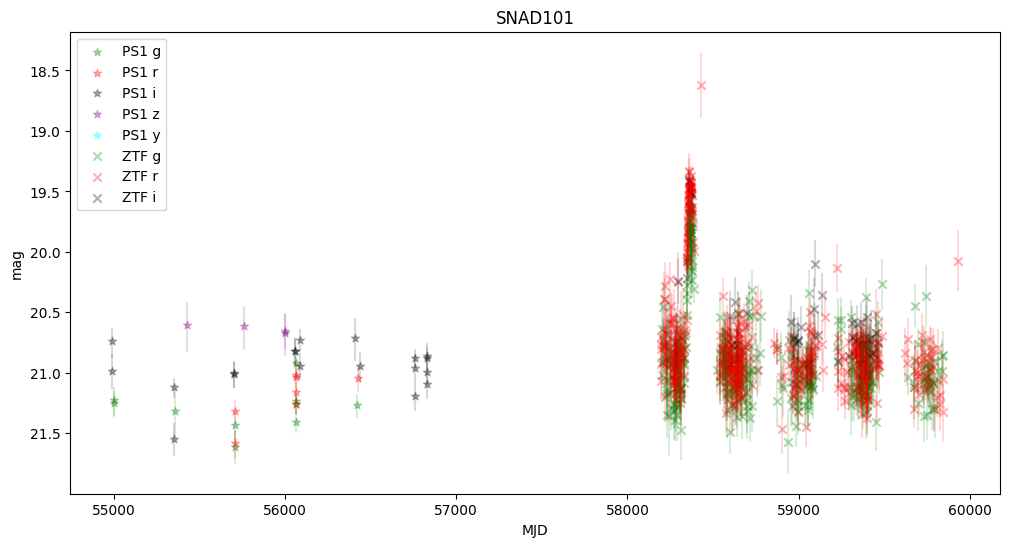

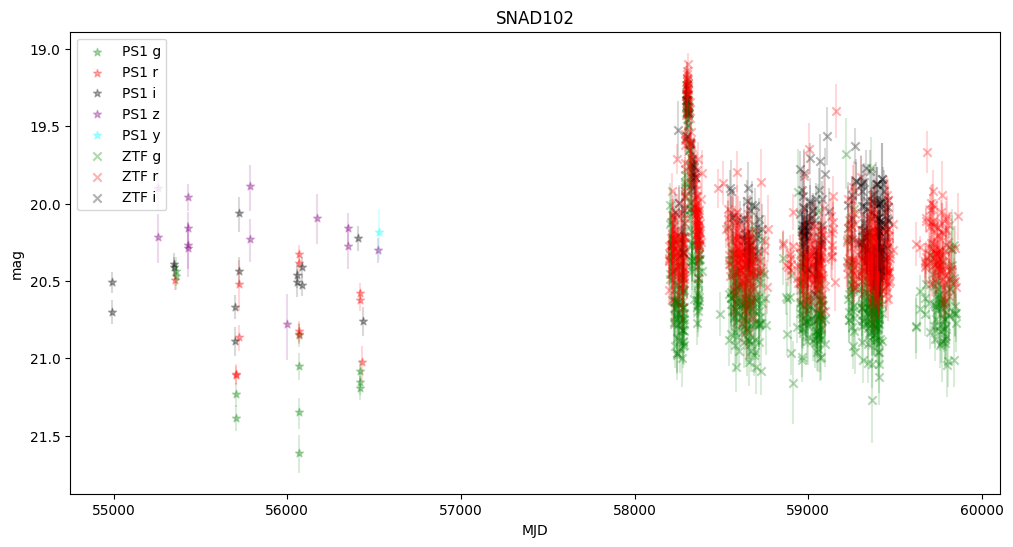

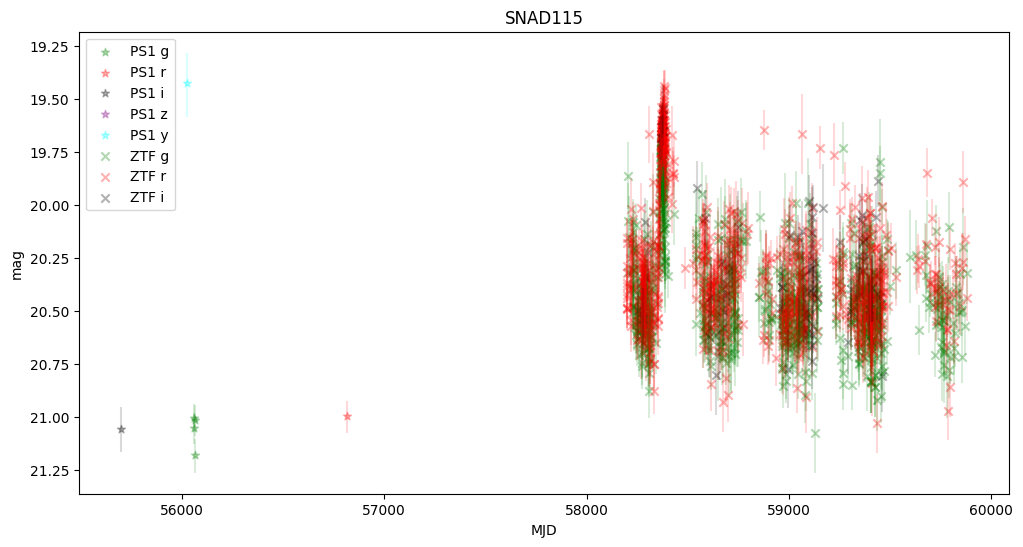

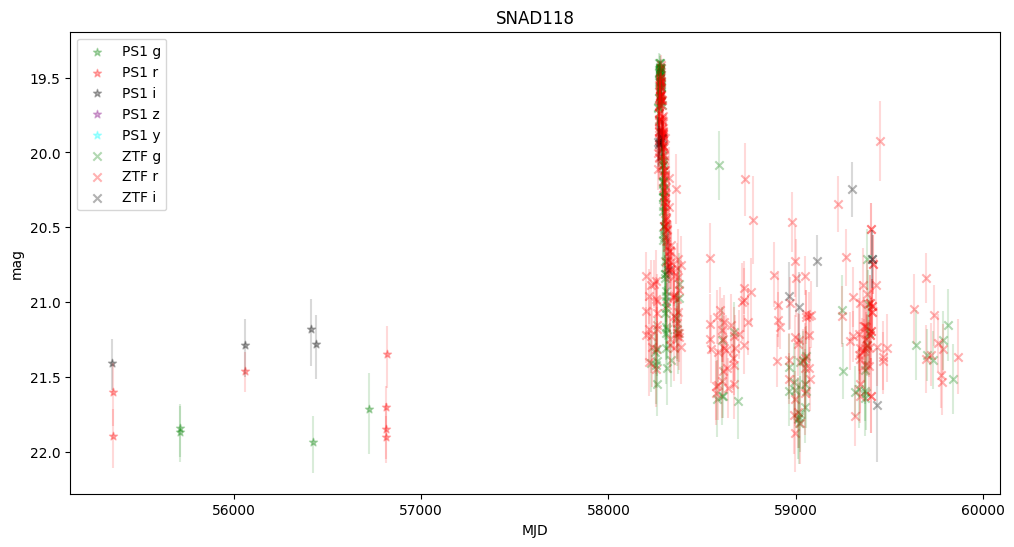

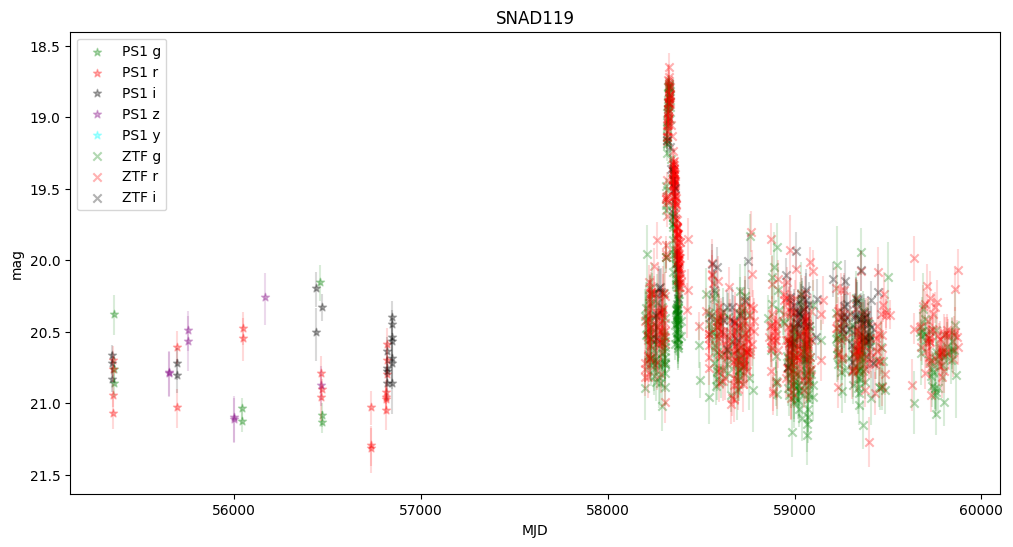

In [9]:
MAG_OR_FLUX = "mag"

ps1_filter_id_to_name = {1: "g", 2: "r", 3: "i", 4: "z", 5: "y"}
get_ps1_name_from_filter_id = np.vectorize(ps1_filter_id_to_name.get)
filter_colors = {"g": "green", "r": "red", "i": "black", "z": "purple", "y": "cyan"}

ndf_sorted = ndf.sort_values("Name")

for i in range(5):
    # snad_name is a string, ps1_lc and ztf_lc are pandas dataframes
    snad_name, ps1_lc, ztf_lc = ndf_sorted.iloc[i][["Name", "ps1_lc", "ztf_lc"]]

    # when we iterate a nested series we are getting pandas dataframes of light curves
    plt.figure(figsize=(12, 6))

    # PS1
    ps1_bands = get_ps1_name_from_filter_id(ps1_lc["filterID"])
    for band in "grizy":
        color = filter_colors[band]
        band_idx = ps1_bands == band
        t = ps1_lc["obsTime"][band_idx]
        flux = ps1_lc["psfFlux"][band_idx] * 1e6  # micro Jy
        err = ps1_lc["psfFluxErr"][band_idx] * 1e6
        mag = 8.9 - 2.5 * np.log10(flux / 1e6)
        mag_plus = 8.9 - 2.5 * np.log10((flux - err) / 1e6)
        mag_minus = 8.9 - 2.5 * np.log10((flux + err) / 1e6)
        if MAG_OR_FLUX == "flux":
            plt.scatter(
                t,
                flux,
                marker="*",
                color=color,
                label=f"PS1 {band}",
                alpha=0.3,
            )
            plt.errorbar(
                t,
                flux,
                err,
                ls="",
                color=color,
                alpha=0.15,
            )
        elif MAG_OR_FLUX == "mag":
            plt.scatter(
                t,
                mag,
                marker="*",
                color=color,
                label=f"PS1 {band}",
                alpha=0.3,
            )
            plt.errorbar(
                t,
                mag,
                [mag - mag_minus, mag_plus - mag],
                ls="",
                color=color,
                alpha=0.15,
            )
        else:
            raise ValueError(f"MAG_OR_FLUX should be mag or flux")

    # ZTF
    ztf_bands = ztf_lc["band"]
    for band in "gri":
        band_idx = ztf_bands == band
        color = filter_colors[band]
        t = ztf_lc["mjd"][band_idx]
        mag = ztf_lc["mag"][band_idx]
        magerr = np.asarray(ztf_lc["magerr"][band_idx], dtype=float) * 1e-4
        flux = np.power(10, 0.4 * (8.9 - mag)) * 1e6  # micro Jy
        err = 0.4 * np.log(10) * flux * magerr
        if MAG_OR_FLUX == "flux":
            plt.scatter(
                t,
                flux,
                marker="x",
                color=color,
                label=f"ZTF {band}",
                alpha=0.3,
            )
            plt.errorbar(
                t,
                flux,
                err,
                ls="",
                color=color,
                alpha=0.15,
            )
        else:
            plt.scatter(
                t,
                mag,
                marker="x",
                color=color,
                label=f"ZTF {band}",
                alpha=0.3,
            )
            plt.errorbar(
                t,
                mag,
                magerr,
                ls="",
                color=color,
                alpha=0.15,
            )

    plt.title(snad_name)
    plt.xlabel("MJD")
    plt.ylabel("Flux, μJy" if MAG_OR_FLUX == "flux" else "mag")
    if MAG_OR_FLUX == "mag":
        plt.gca().invert_yaxis()
    plt.legend(loc="upper left")

We observe that some objects are missing—this is because Pan-STARRS lacked information about the transients, and the host center is either too faint or too distant from the transient.

None of these objects were active in Pan-STARRS, but they were active in ZTF, confirming that they are robust supernova candidates.

## About

**Authors**: Konstantin Malanchev

**Last updated on**: Oct 27, 2025

If you use `lsdb` for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).